In [439]:
import numpy as np
import sympy as sp
from pyqubo import Array, Constraint
from dwave.samplers import SimulatedAnnealingSampler
import matplotlib.pyplot as plt
from pprint import pprint

In [440]:
def qubo_vars(model):
    qubo, offset = model.to_qubo()

    vars = []
    for k, v in qubo.items():
        v1, v2 = k
        if v1 not in vars:
            vars.append(v1)
        if v2 not in vars:
            vars.append(v2)
    return vars

In [441]:
MODO_RPOS = 1
MODO_RPOS_RNEG = 2
MODO_RPOS_1NEG = 3

J0 = 3

def prepare_qubo_bin(modo, base, n):
    if modo == MODO_RPOS:
        R = base
        x_bin = Array.create('x', shape=(n, R), vartype='BINARY')
        bin_size = n*R
        x_vec = [sum(2**(J0-j) * x_bin[i][j] for j in range(R)) for i in range(n)]
    elif modo == MODO_RPOS_RNEG:
        R = base // 2
        x_bin = Array.create('x', shape=(n, R, 2), vartype='BINARY')
        bin_size = n*R*2
        x_vec = [(sum(2**(J0-j) * x_bin[i][j][0] for j in range(R)) - sum(2**(J0-j) * x_bin[i][j][1] for j in range(R))) for i in range(n)]
    elif modo == MODO_RPOS_1NEG:
        R = base - 1
        x_bin = Array.create('x', shape=(n, R+1), vartype='BINARY')
        bin_size = n*(R+1)
        x_vec = [(sum(2**(J0-j) * x_bin[i][j] for j in range(R)) - 2**(J0+1) * x_bin[i][R]) for i in range(n)]
    else:
        raise RuntimeError("todo")
    
    print(f"QUBO parameters: {bin_size}")
    return (x_bin, x_vec, bin_size, R)

def parse_qubo_bin(modo, sol, n, R):
    # Decodificación del resultado binario a real
    x_sol = np.zeros(n)

    if modo == MODO_RPOS:
        for i in range(n):
            for j in range(R):
                bit_name = f'x[{i}][{j}]'
                bit_val = sol[bit_name]
                x_sol[i] += bit_val * 2**(J0-j)
    elif modo == MODO_RPOS_RNEG:
        for i in range(n):
            for j in range(R):
                pos_bit_name = f'x[{i}][{j}][0]'
                pos_bit_val = sol[pos_bit_name]
                x_sol[i] += pos_bit_val * 2**(J0-j)
                neg_bit_name = f'x[{i}][{j}][1]'
                neg_bit_val = sol[neg_bit_name]
                x_sol[i] -= neg_bit_val * 2**(J0-j)
    elif modo == MODO_RPOS_1NEG:
        for i in range(n):
            for j in range(R):
                pos_bit_name = f'x[{i}][{j}]'
                pos_bit_val = sol[pos_bit_name]
                x_sol[i] += pos_bit_val * 2**(J0-j)
            
            neg_bit_name = f'x[{i}][{R}]'
            neg_bit_val = sol[neg_bit_name]
            x_sol[i] -= neg_bit_val * 2**(J0+1)
    else:
        raise RuntimeError("todo")

    return x_sol

In [442]:
def random_syslin(n):
    vmax = 5
    vmin = -5
    A = np.random.randint(vmin, vmax+1, size=(n, n))
    b = np.random.randint(vmin, vmax+1, size=(n))
    return (A, b)

In [443]:
def syslin_solve_np(A, b):
    Ainv = np.linalg.inv(A)
    return np.matmul(Ainv, b)

In [444]:
def syslin_solve_qubo(modo, A, b, base, n):
    x_bin, x_vec, bin_size, R = prepare_qubo_bin(modo, base, n)

    objective = sum((sum(A[i, j] * x_vec[j] for j in range(n)) - b[i])**2 for i in range(n))
    H = Constraint(objective, label="Ax_minus_b")

    model = H.compile()
    vars = qubo_vars(model)
    print(f"QUBO compiled vars: {len(vars)}")
    bqm = model.to_bqm()

    sampler = SimulatedAnnealingSampler()
    sampleset = sampler.sample(bqm, num_reads=10)

    # Decodificar la mejor solución
    decoded = model.decode_sampleset(sampleset)
    best = min(decoded, key=lambda x: x.energy)
    solution = best.sample

    return parse_qubo_bin(modo, solution, n, R)

In [445]:
def compare_sol(n, x_clas, x_qubo, title, fig, ax):
    rel_errs = [100*abs((x_qubo[i] - x_clas[i]) / x_clas[i]) for i in range(n)]
    rel_err_labels = [f"{i}" for i in range(n)]

    # Plotting
    ax.bar(rel_err_labels, rel_errs, color='skyblue')
    ax.set_ylabel("Relative error (%)")
    ax.set_title(title)

    # Optional: add value labels on top of bars
    for i, v in enumerate(rel_errs):
        ax.text(i, v + 1, f"{v:.3f}%", ha='center', fontsize=6)

    ax.set_ylim(0, max(rel_errs) + 10)  # Add headroom for labels
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    

def test(base, n, A, b):
    x_clas = syslin_solve_np(A, b)

    fig, axes = plt.subplots(1, 3, figsize=(5,5))

    x_qubo1 = syslin_solve_qubo(MODO_RPOS, A, b, base, n)
    compare_sol(n, x_clas, x_qubo1, "MODO_RPOS", fig, axes[0])

    x_qubo2 = syslin_solve_qubo(MODO_RPOS_RNEG, A, b, base, n)
    compare_sol(n, x_clas, x_qubo2, "MODO_RPOS_RNEG", fig, axes[1])

    x_qubo3 = syslin_solve_qubo(MODO_RPOS_1NEG, A, b, base, n)
    compare_sol(n, x_clas, x_qubo3, "MODO_RPOS_1NEG", fig, axes[2])

    plt.tight_layout()
    plt.show()

    print(f"C: {x_clas}")
    print(f"Q1: {x_qubo1}")
    print(f"Q2: {x_qubo2}")
    print(f"Q3: {x_qubo3}")

QUBO parameters: 48
QUBO compiled vars: 48
QUBO parameters: 48
QUBO compiled vars: 48
QUBO parameters: 48
QUBO compiled vars: 48


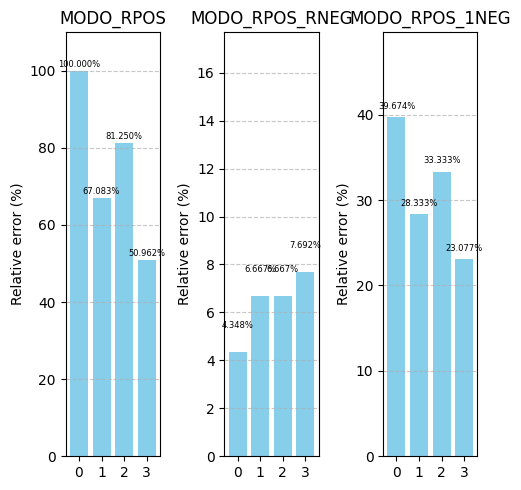

C: [-1.4375  0.9375  3.75    0.8125]
Q1: [0.         0.30859375 0.703125   0.3984375 ]
Q2: [-1.5   1.    4.    0.75]
Q3: [-2.0078125  1.203125   5.         1.       ]


In [446]:
# Test

n = 4
base = 12
A, b = random_syslin(n)
test(base, n, A, b)

**Cuadrático**

In [447]:
def sysquad_count_compiled_qubo(modo, Q, A, b, n, R, force):
    x_bin, x_vec, ctx, bin_size = prepare_qubo_bin(modo, n, R)

    objective = sum((sum(Q[i,j,k]*x_vec[j]*x_vec[k] for j in range(n) for k in range(n)) + sum(A[i,j]*x_vec[j] for j in range(n)) - b[i])**2 for i in range(n))
    H = Constraint(objective, label="Qxx_Ax_minus_b")

    model = H.compile(strength=force)
    bqm = model.to_bqm()
    vars = qubo_vars(model)
    return (bin_size, len(vars))

In [448]:
def sysquad_solve_qubo(modo, Q, A, b, n, R, force):
    x_bin, x_vec, ctx, bin_size = prepare_qubo_bin(modo, n, R)

    objective = sum((sum(Q[i,j,k]*x_vec[j]*x_vec[k] for j in range(n) for k in range(n)) + sum(A[i,j]*x_vec[j] for j in range(n)) - b[i])**2 for i in range(n))
    H = Constraint(objective, label="Qxx_Ax_minus_b")

    model = H.compile(strength=force)
    bqm = model.to_bqm()
    vars = qubo_vars(model)
    print(f"QUBO compiled vars: {len(vars)} {vars}")

    sampler = SimulatedAnnealingSampler()
    sampleset = sampler.sample(bqm, num_reads=200)

    # Decodificar la mejor solución
    decoded = model.decode_sampleset(sampleset)
    best = min(decoded, key=lambda x: x.energy)
    solution = best.sample

    return parse_qubo_bin(modo, solution, n, R, ctx)

In [449]:
def sysquad_solve_sp(n, Q, A, b, x0):
    x = sp.symbols(f'x0:{n}')

    # Convert to sympy Float for numerical stability (optional)
    Q_sp = sp.ImmutableDenseNDimArray(Q.tolist())
    A_sp = sp.ImmutableMatrix(A.tolist())
    b_sp = sp.ImmutableMatrix(b.tolist())

    equations = []
    for i in range(n):
        eq = sum(Q_sp[i,j,k]*x[j]*x[k] for j in range(n) for k in range(n)) + sum(A_sp[i,j]*x[j] for j in range(n)) - b_sp[i]
        equations.append(eq)

    # Solve numerically
    return np.array(list(sp.nsolve(equations, x, x0)))

In [450]:
def print_sysquad(n, Q, A, b):
    for i in range(n):
        print(f"Eq[{i}]: ", end="")
        for j in range(n):
            for k in range(n):
                if Q[i,j,k] != 0:
                    print(f"+{Q[i,j,k]}*x{j}*x{k} ", end="")
        for j in range(n):
            if A[i,j] != 0:
                print(f"+{A[i,j]}*x{j} ", end="")
        
        print(f"= {b[i]}")

def test_sysquad(n, Q, A, b, x_sol):
    for i in range(n):
        val_i = 0

        print(f"EqTest[{i}]: ", end="")
        for j in range(n):
            for k in range(n):
                val_i += Q[i,j,k]*x_sol[j]*x_sol[k]
        for j in range(n):
            if A[i,j] != 0:
                val_i += A[i,j]*x_sol[j]
        
        print(f"{val_i} = {b[i]} (?)")

In [ ]:
def test(nmax, R, tries):
    xs = []
    ys = []
    for n in range(2, nmax):
        cur_xs = []
        cur_ys = []
        for i in range(tries):
            Q = np.random.rand(n, n, n)
            A = np.random.rand(n, n)
            b = np.random.rand(n)

            x, y = sysquad_count_compiled_qubo(MODO_RPOS_RNEG, Q, A, b, n, R, 5.0)
            cur_xs.append(x)
            cur_ys.append(y)
        xs.append(sum(cur_xs) / len(cur_xs))
        ys.append(sum(cur_ys) / len(cur_ys))

    # Plot first set of points with a line
    plt.plot(xs, ys, label='Line 1', marker='o')

    # Add labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Two Line Plots')

    # Show legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    return xs, ys

xs, ys = test(7, 4, 3)

QUBO parameters: 8
QUBO parameters: 8
QUBO parameters: 8
QUBO parameters: 8
QUBO parameters: 8
QUBO parameters: 8
QUBO parameters: 16
QUBO parameters: 16
QUBO parameters: 16
QUBO parameters: 16


IndexError: list index out of range

: 

R=3: y=0.5*x*(x+1)

In [ ]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial

# Fit quadratic (degree 2)
coeffs_quadratic = np.polyfit(xs, ys, deg=2)
p_quadratic = np.poly1d(coeffs_quadratic)
y_fit_quadratic = p_quadratic(xs)

a, b, c = coeffs_quadratic

# Print the quadratic formula
print(f"y = {a:.3f}x² + {b:.3f}x + {c:.3f}")


y = 0.500x² + 0.500x + 0.000


In [ ]:
from scipy.optimize import curve_fit

def exp_func(x, a, b):
    return a * np.exp(b * x)

params_exp, _ = curve_fit(exp_func, xs, ys)
y_fit_exp = exp_func(np.array(xs), *params_exp)


In [ ]:
from sklearn.metrics import r2_score

r2_quad = r2_score(ys, y_fit_quadratic)
r2_exp = r2_score(ys, y_fit_exp)

print("Quadratic R²:", r2_quad)
print("Exponential R²:", r2_exp)


Quadratic R²: 1.0
Exponential R²: 0.9869760685133141


In [ ]:
# Quad test

n = 2

A = np.array([[0, 2],
              [1, 1]])

Q = np.zeros((n, n, n))
Q[0,0,1] = 1

b = np.array([1, 2])

print_sysquad(n, Q, A, b)

x_clas = sysquad_solve_sp(n, Q, A, b, [1.0, 1.0])
print(f"C: {x_clas}")
test_sysquad(n, Q, A, b, x_clas)

x_sol = sysquad_solve_qubo(MODO_RPOS, Q, A, b, n, 8, 10.0)
print(f"Q: {x_sol}")
test_sysquad(n, Q, A, b, x_sol)

Eq[0]: +1.0*x0*x1 +2*x1 = 1
Eq[1]: +1*x0 +1*x1 = 2
C: [1.73205080756888 0.267949192431123]
EqTest[0]: 1.00000000000000 = 1 (?)
EqTest[1]: 2.00000000000000 = 2 (?)
QUBO parameters: 16
QUBO compiled vars: 136 ['x[1][4]', 'x[0][6] * x[0][0]', 'x[1][7] * x[1][2]', 'x[1][7] * x[1][1]', 'x[0][5] * x[0][3]', 'x[1][6]', 'x[0][6] * x[0][1]', 'x[1][4] * x[0][5]', 'x[1][3]', 'x[1][3] * x[1][0]', 'x[0][7] * x[0][1]', 'x[0][6]', 'x[1][5] * x[1][3]', 'x[0][3] * x[0][1]', 'x[1][7] * x[1][0]', 'x[1][6] * x[1][1]', 'x[0][4] * x[0][2]', 'x[0][7] * x[0][5]', 'x[1][6] * x[1][3]', 'x[1][5]', 'x[0][3] * x[0][2]', 'x[1][4] * x[1][2]', 'x[0][4]', 'x[1][6] * x[0][4]', 'x[0][1]', 'x[1][2] * x[1][1]', 'x[1][1]', 'x[1][4] * x[1][3]', 'x[0][5] * x[0][2]', 'x[1][7] * x[1][4]', 'x[0][2] * x[0][0]', 'x[0][7] * x[0][3]', 'x[1][2]', 'x[1][2] * x[0][7]', 'x[1][5] * x[1][4]', 'x[0][5]', 'x[1][5] * x[1][2]', 'x[0][1] * x[0][0]', 'x[1][5] * x[1][1]', 'x[0][0]', 'x[1][6] * x[0][1]', 'x[0][2] * x[0][1]', 'x[1][6] * x[1][0]',